توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture
!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import matplotlib.pyplot as plt

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
def displacement(img, dx, dy):
    r, c = img.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])

    new_cols = c - abs(dx)
    new_rows = r - abs(dy)

    new_img = cv2.warpAffine(img, M, (c, r))
    new_x = max(dx, 0)
    new_y = max(dy, 0)
    new_img = new_img[new_y:new_y + new_rows, new_x:new_x + new_cols]
    return new_img


def rotation(input_img, rotation_angle):
    r, c = input_img.shape[:2]
    transformation_matrix = cv2.getRotationMatrix2D((c/2, r/2), rotation_angle, 1)
    cos_theta = np.abs(transformation_matrix[0, 0])
    sin_theta = np.abs(transformation_matrix[0, 1])

    new_width = int((r * sin_theta) + (c * cos_theta))
    new_height = int((r * cos_theta) + (c * sin_theta))

    transformation_matrix[0, 2] += (new_width / 2) - c/2
    transformation_matrix[1, 2] += (new_height / 2) - r/2

    rotated_img = cv2.warpAffine(input_img, transformation_matrix, (new_width, new_height))

    angle_rad = np.deg2rad(rotation_angle)
    quadrant = int(np.floor(angle_rad / (np.pi / 2))) & 3
    sign_alpha = quadrant & 1 == 0
    alpha = (angle_rad if sign_alpha else np.pi - angle_rad) % np.pi
    bb_w = (r * np.sin(alpha) + c * np.cos(alpha))
    bb_h = (r * np.cos(alpha) + c * np.sin(alpha))

    gamma = np.arctan2(bb_w, bb_w - r * np.sin(alpha)) if c <= r else np.arctan2(bb_h, bb_h - c * np.sin(alpha))

    delta = np.pi - alpha - gamma
    length = r if c <= r else c
    d = length * np.cos(alpha)
    a = d * np.sin(alpha) / np.sin(delta)
    y = a * np.cos(gamma)
    x = y * np.tan(gamma)

    crop_width = int(c - 2 * x)
    crop_height = int(r - 2 * y)

    new_x = int((new_width - crop_width) / 2)
    new_y = int((new_height - crop_height) / 2)
    cropped_img = rotated_img[new_y:new_y+crop_height, new_x:new_x+crop_width]

    return cropped_img



def resizing(image, dim = (224, 224)):
    return cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

def scaling(image, scale_percent):
    w = int(image.shape[1] * scale_percent / 100)
    h = int(image.shape[0] * scale_percent / 100)
    dim = (w, h)
    scaled_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return scaled_image


def resizing(image, dim = (224, 224)):
    return cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)






def brightness(img):
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(np.random.uniform(0.5, 1.5))
    return img

# Function 5: Blurring
def blurring(img):
    radius = np.random.uniform(0, 2)
    img = img.filter(ImageFilter.GaussianBlur(radius))
    return img

# Function 6: Gaussian Noise

def gaussian_noise(img):
    noise = np.random.normal(scale=25, size=(img.size[1], img.size[0], 3))
    img_array = np.array(img)
    img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    return img






In [ ]:
from torch.utils.data import Dataset
import random
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self,train,A ,prefix,data_len,gray, transform=None):
        self.train = train
        self.transform = transform
        self.valid_indices = []
        self.data_dir =A
        self.prefix = prefix
        self.data_len = data_len
        self.grayscale_indices = gray
        self.valid_indices = [i for i in range(self.data_len) if i+1 not in self.grayscale_indices]
        self.mods = [self.random_mods() for _ in range(len(self.valid_indices))]

    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        if self.train:
            img_name = f'{self.prefix}{str(valid_idx+1).zfill(8)}.jpg'
        else:
            with open(os.path.join(self.data_dir, 'list.txt'), 'r') as f:
                image_names = [line.strip() for line in f]

            img_name = os.path.join(self.prefix, image_names[valid_idx])

        img_path = os.path.join(self.data_dir, img_name)
        original_image = Image.open(img_path).convert('RGB')

        modified_image = np.array(original_image)

        label = np.array([0, 0, 0])

        mods = self.mods[idx]

        for mod in mods:
            if mod == 'scaling':
                scale_percent = random.sample([50, 200], 1)[0]
                modified_image = scaling(modified_image, scale_percent)
                label[0] = 1
            elif mod == 'rotation':
                angle = 15
                modified_image = rotation(modified_image, angle)
                label[2] = 1
            elif mod == 'displacement':
                dx = 50
                dy = 10
                modified_image = displacement(modified_image, dx, dy)
                label[1] = 1



        modified_image = Image.fromarray(modified_image)
        original_image = self.transform(original_image)
        modified_image = self.transform(modified_image)

        return original_image, modified_image, label

    def __len__(self):
        return len(self.valid_indices)

    def random_mods(self):
        mods = ['scaling', 'displacement', 'rotation']
        return random.sample(mods, random.randint(1, 2))


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


file_paths_list_train = glob.glob("ADEChallengeData2016/images/training/*.jpg")
file_paths_list_test = glob.glob("release_test/testing/*.jpg")

dataset_train = CustomDataset(train=True,A='ADEChallengeData2016/images/training/' ,prefix='ADE_train_',data_len=20210,gray={13508, 3020, 8455, 1701}, transform=transform)
dataset_test = CustomDataset(train=False,A='/content/release_test/' ,prefix='testing',data_len=3352,gray={1270, 487, 1665, 610, 1952, 503}, transform=transform)

batch_size = 16
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)



def show_image(data_loader, title):

    fig, axes = plt.subplots(2, 8, figsize=(25, 8))
    fig.suptitle(title)
    for i, (original, modified, label) in enumerate(data_loader):
        if i >= 8:
            break
        originaly = original[i].numpy().transpose((1, 2, 0))
        modifieds = modified[i].numpy().transpose((1, 2, 0))
        axes[0, i].imshow(originaly)
        axes[0, i].set_title(f'Original\nLabel: {label[i]}')
        axes[1, i].imshow(modifieds)
        axes[1, i].set_title(f'Modified\nLabel: {label[i]}')

    # Show the plot
    plt.show()



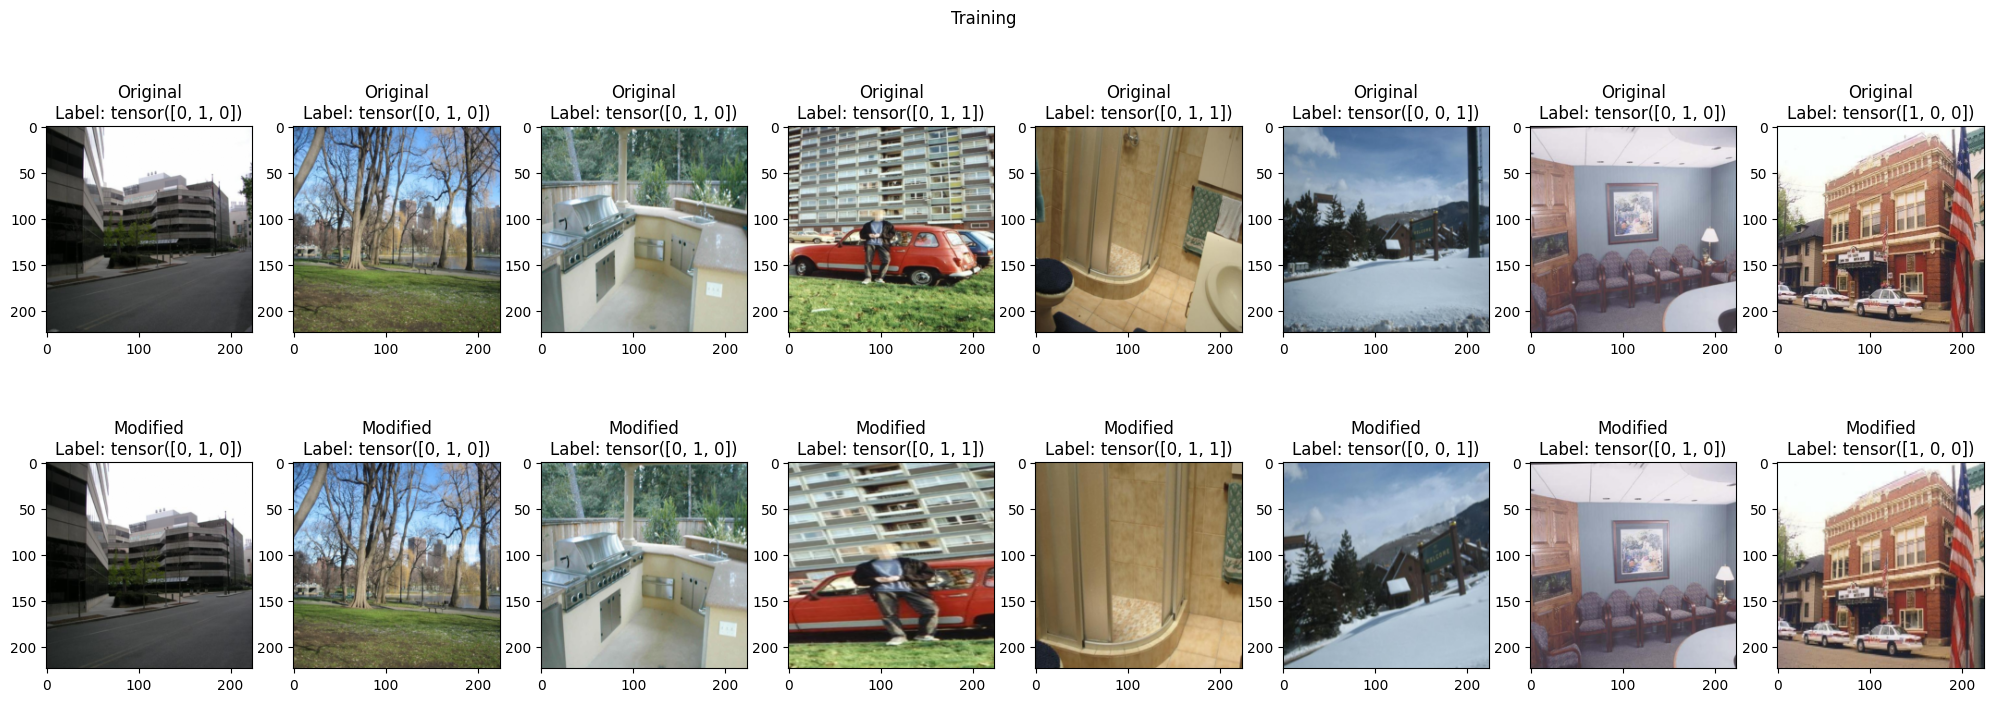

In [ ]:
show_image(train_loader, 'Training')


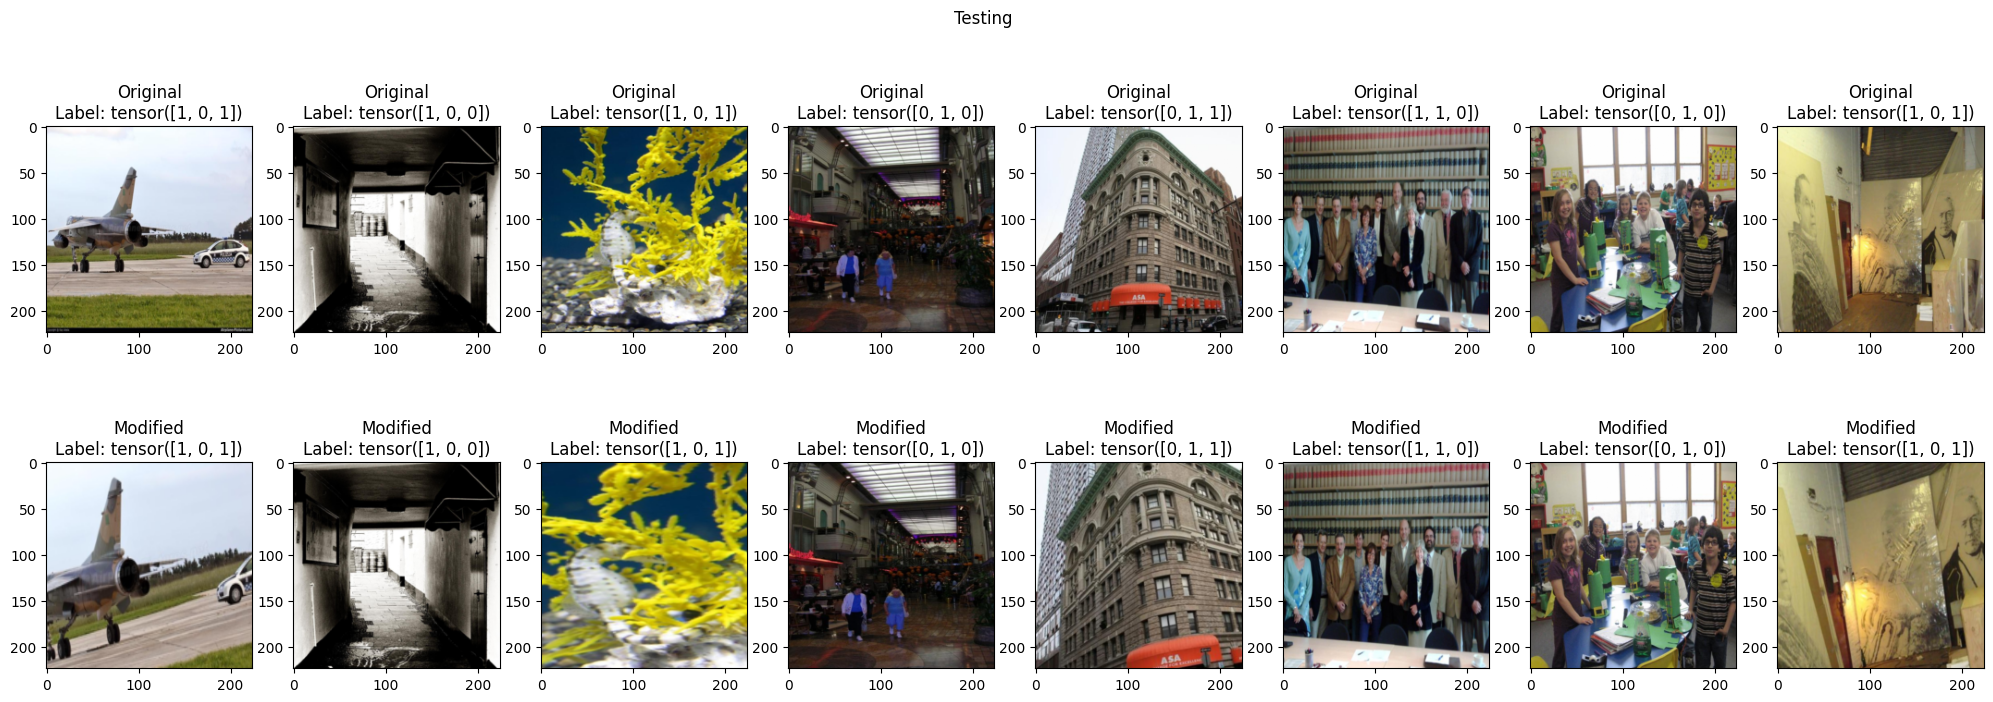

In [ ]:
show_image(test_loader, 'Testing')

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

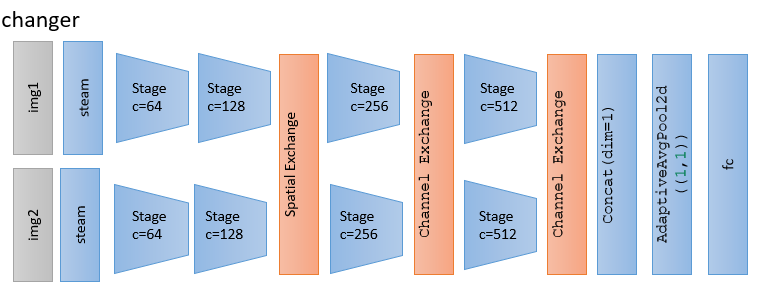

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


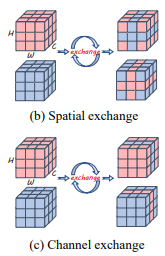

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

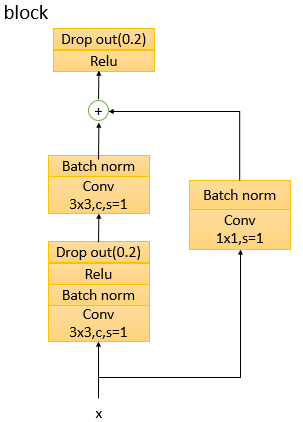

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





پدینگ ها را همه را 1 در نظر گرفتیم تا از لحاط ابعادی به مشکل نخوریم
و با توجه به هر کدام از این ورودی های لایه های بعد خروجی لایه فعلی را تعیین می کنیم.



دلیل استفاده از کانولوشن یک در یک صرفا تغییر تعداد کانال های داده مان می باشد

In [ ]:
##To Do

class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.right =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        self.result = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2)
        )


    def forward(self, x):

        left = self.left(x)
        right = self.right(x)
        out = left + right
        out = self.result(out)
        return out





In [ ]:
class steam(nn.Module):
    def __init__(self, in_channels, out_channels=64):
        super(steam, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def forward(self, x):
        return self.block(x)

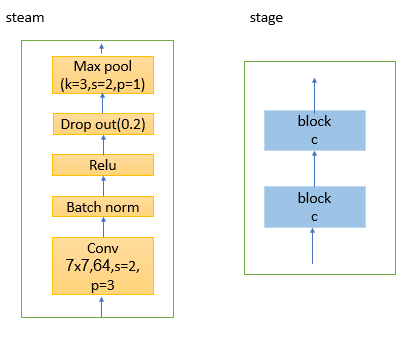

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
import torch
import torch.nn as nn

class changer(nn.Module):
    def __init__(self, SpatialExchange, ChannelExchange, in_channels=3):
        super(changer, self).__init__()
        self.stage1 = nn.Sequential(
            steam(in_channels),
            block(64, 64),
            block(64, 64),
            block(64, 128),
            block(128, 128)
        )
        self.stage2 = nn.Sequential(
            block(128, 256),
            block(256, 256)
        )
        self.stage3 = nn.Sequential(
            block(256, 512),
            block(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 3)

    def forward(self, x1, x2):

        x1 = self.stage1(x1)
        x2 = self.stage1(x2)
        x1, x2 = SpatialExchange(x1, x2)
        x1 = self.stage2(x1)
        x2 = self.stage2(x2)
        x1, x2 = ChannelExchange(x1, x2)
        x1 = self.stage3(x1)
        x2 = self.stage3(x2)
        x1, x2 = ChannelExchange(x1, x2)
        out = torch.cat((x1, x2), 1)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SpatialExchange = SpatialExchange()
ChannelExchange = ChannelExchange()
model=changer(SpatialExchange, ChannelExchange).to(device)



Epoch 1, Loss: 0.38425290175165716, Accuracy per label: [0.6573421955108643, 0.7492789030075073, 0.9510589838027954], Overall Accuracy: 78.58936190605164%
Epoch 2, Loss: 0.312555387899315, Accuracy per label: [0.6757790446281433, 0.8133836984634399, 0.9884204268455505], Overall Accuracy: 82.58612155914307%
Epoch 3, Loss: 0.29683951664235225, Accuracy per label: [0.6783522367477417, 0.8301591873168945, 0.9932205080986023], Overall Accuracy: 83.39108228683472%
Finished Training


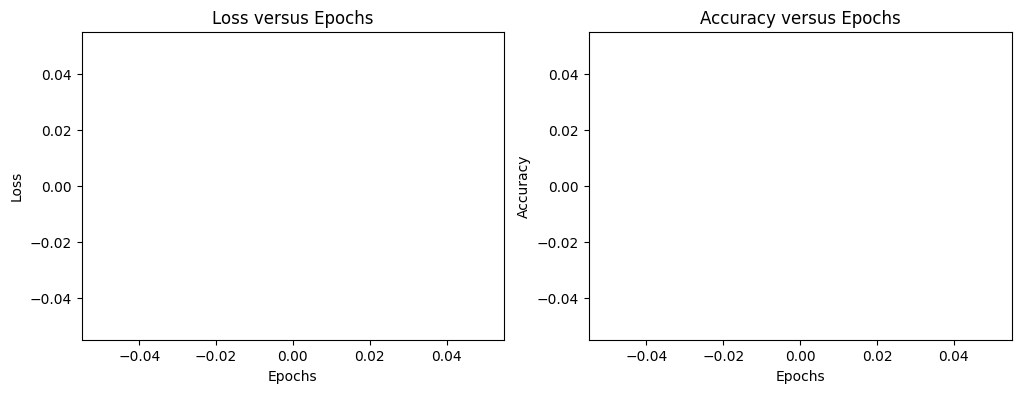

In [ ]:
# Train the model
criterion_custom = nn.BCEWithLogitsLoss()
optimizer_custom = optim.Adam(model.parameters(), lr=0.00014)
model.train()
loss_values_custom = []
accuracy_values_custom = []
for epoch_custom in range(3):
    running_loss_custom = 0.0
    correct_custom = 0
    total_custom = 0
    accuracy_per_label_custom = 0
    overall_accuracy_custom = 0
    for i_custom, data_custom in enumerate(train_loader_custom, 0):

        original_images_custom, modified_images_custom, labels_custom = data_custom

        original_images_custom = original_images_custom.to(device_custom)
        modified_images_custom = modified_images_custom.to(device_custom)
        labels_custom = labels_custom.to(device_custom)
        labels_custom = labels_custom.float()

        optimizer_custom.zero_grad()

        outputs_custom = model_custom(original_images_custom, modified_images_custom)
        loss_custom = criterion_custom(outputs_custom, labels_custom)
        loss_custom.backward()
        optimizer_custom.step()

        probabilities_custom = torch.sigmoid(outputs_custom)

        threshold_custom = 0.5
        predicted_custom = (probabilities_custom >= threshold_custom).float()

        correct_predictions_custom = (predicted_custom == labels_custom).float()

        accuracy_per_label_custom += correct_predictions_custom.sum(0) / len(original_images_custom)

        overall_accuracy_custom += correct_predictions_custom.sum() / (len(original_images_custom) * 3)
        running_loss_custom += loss_custom.item()

    torch.save(model_custom.state_dict(), 'model_parameters_custom.pth')
    accuracy_per_label_custom = accuracy_per_label_custom / len(train_loader_custom)
    overall_accuracy_custom = overall_accuracy_custom / (len(train_loader_custom))
    print(f'Epoch {epoch_custom + 1}, Loss: {running_loss_custom / len(train_loader_custom)}, '
          f'Accuracy per label: {accuracy_per_label_custom.tolist()}, '
          f'Overall Accuracy: {overall_accuracy_custom.item() * 100}%')

print('Finished Training')


#Test


In [ ]:

model_evaluation = model.eval()

accuracy_per_label_test_custom = torch.zeros(3).to(device)
overall_accuracy_test_custom = 0

with torch.no_grad():
    for data_custom in test_loader:
        original_images_custom, modified_images_custom, labels_custom = data_custom
        original_images_custom = original_images_custom.to(device)
        modified_images_custom = modified_images_custom.to(device)
        labels_custom = labels_custom.to(device)
        labels_custom = labels_custom.float()

       
        outputs_custom = model_evaluation(original_images_custom, modified_images_custom)

        probabilities_custom = torch.sigmoid(outputs_custom)

        threshold_custom = 0.5
        predicted_custom = (probabilities_custom >= threshold_custom).float()

        correct_predictions_custom = (predicted_custom == labels_custom).float()

        accuracy_per_label_test_custom += correct_predictions_custom.sum(0) / (len(original_images_custom))

        overall_accuracy_test_custom += correct_predictions_custom.sum() / (len(original_images_custom) * 3)

accuracy_per_label_test_custom /= len(test_loader)

overall_accuracy_test_custom /= len(test_loader)

print(f'Accuracy per label: {accuracy_per_label_test_custom.tolist()}, '
      f'Overall Accuracy: {overall_accuracy_test_custom.item() * 100}%')


Accuracy per label: [0.6988095641136169, 0.8354166746139526, 0.9991071820259094], Overall Accuracy: 84.44448113441467%


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

همان طور که دیده می شود کلاس هایی که اسکیل داشتند با دقت پایین تری نسبت به دو کلاس دیگر تشخیص داده شدند
و کلاس چرخش از همه بهتر تشخیص داده می شد
(با دقت 99 درصد)

#نحوه آماده سازی دیتاست
در واقع ما یک سری تابع برای تغییر عکس از حالت معمولی ب همودیفای شده را داریم
و در این بین 3 تابع اصلی چرخش اسکیلینگ و جابجایی را داریم

حال در تابع

custom dataset

ما هر عکس را گرفته و به طور رندم یکی از این تغییرات اصلی را روی آن اعمال می کنیمو بر همین اساس به آن لیبل متناظر را می دهیم و در خروجی عکس اصلی و عکس کودیفای شده و لیبل متناطر را خروجی می دهیم.